In [1]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options as FF_Options
import pandas as pd
from time import sleep
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from IPython.display import clear_output

In [2]:
sns.set_style('whitegrid')

In [3]:
class LinkScraper():
    def __init__(self, headless=True):
        options = FF_Options()
        if headless: options.add_argument("--headless")
        self.driver = webdriver.Firefox(options=options)
        self.transfer_df = pd.DataFrame()
    
    def _parse_odds(self,odds_val):
        odds_str = str(odds_val)
        if '/' in odds_str:
            num, denom = odds_str.split('/')
            return int(num) / int(denom)
        else:
            try:
                return float(odds_str)
            except:
                return np.nan
    
    def _parse_link(self, link):
        self.driver.get(link)
        tables = pd.read_html(self.driver.page_source)
        # Odds table seems to be last table on page
        odds_df = tables[-1]
        # Remove crazy long column names
        odds_df.columns = [''] * len(odds_df.columns)
        # Transpose - clubs along axis
        clean_df = odds_df.T.rename(columns=odds_df.T.iloc[0])
        # Calculate lowest odds - most likely
        long_df = pd.DataFrame(clean_df.applymap(self._parse_odds).min()).reset_index()
        # Add in column names, including player name
        long_df.columns = ['destination', 'odds']
        long_df['player'] = link.split('/')[-2].replace('-',' ').title()
        # add probability and date
        long_df['probability'] = 1 / (1 + long_df['odds'])
        long_df['date'] = datetime.now().date()
        self.transfer_df = self.transfer_df.append(long_df, sort=False)
        
    def _get_links(self):
        url = 'https://www.oddschecker.com/football/football-specials'
        self.driver.get(url)
        sleep(1)
        #Sometimes there is annoying popup
        try:
            driver.find_element_by_xpath('//*[@id="promo-modal"]/div[1]/div/div/div[5]/a').click()
        except:
            pass
        sleep(1)
        #Find the transfer rumours
        markets = self.driver.find_element_by_xpath('//*[@id="outrights"]/div/ul').find_elements_by_tag_name('li')
        links = [m.find_element_by_tag_name('a').get_attribute('href') for m in markets]
        self.transfer_links = [l for l in links if  'club-after-summer-transfer-window' in l]
        
    def get_and_parse_all_links(self):
        try:
            self._get_links()
            for i, l in enumerate(self.transfer_links):
                clear_output()
                print(f'{l} \n {i+1}/{len(self.transfer_links)} \n')
                self._parse_link(l)
                # Append to df
            return self.transfer_df
        except Exception as e:            
            raise e
        finally:
            self.driver.quit()

In [4]:
link_scrap = LinkScraper()
combined_df = link_scrap.get_and_parse_all_links()

https://www.oddschecker.com/football/player-specials/sadio-mane/club-after-summer-transfer-window 
 76/76 



## Plotting

plotting functions, by club and by player

In [5]:
def make_bar_chart(df,filter_var,y_var ,filter_val, title ,show_flag=False):
    filter_df = df.loc[(df[filter_var]==filter_val) &
                             (df.probability > 0)].sort_values(by='probability',ascending=False)
    if filter_df.shape[0] > 2:
        plt.subplots(figsize=(20,15))
        ax = sns.barplot(data=filter_df,y=y_var,x='probability',orient='h')
        locs, labels = plt.xticks()
        plt.setp(labels, rotation=90)
        ax.set_title(title,{'fontsize':20})
        plt.savefig(f'output/{filter_var}s/{filter_val}.png')
        if show_flag: plt.show()
        plt.close()

In [6]:
def plot_most_likely(df, n):
    most_likely = (combined_df
                   .loc[~combined_df.destination.str.contains('To Stay|To Leave|Any|Not to sign')]
                   .sort_values(by='probability',ascending=False)
                   .head(n))
    most_likely['transfer'] = most_likely.player + ' - ' + most_likely['destination']
    plt.subplots(figsize=(20,15))
    ax = sns.barplot(data=most_likely,y='transfer',x='probability',orient='h')
    ax.set_title(f'{n} most likely Transfers \n',{'fontsize':20})
    plt.savefig(f'output/{n} most likely overall.png')

In [7]:
!rm -rf output/players
!rm -rf output/destinations
!mkdir output/players
!mkdir output/destinations

In [8]:
for dest in combined_df.loc[~combined_df.destination.str.contains('To Stay|To Leave|Any')
                            ,'destination'].unique():
    make_bar_chart(df=combined_df,
                   filter_var='destination',
                   y_var='player',
                   filter_val=dest,
                   title=f'{dest} Transfer Targets \n')

In [9]:
for player in combined_df.player.unique():
     make_bar_chart(df=combined_df,
                   filter_var='player',
                   y_var='destination',
                   filter_val=player,
                   title=f'{player} Destinations \n')

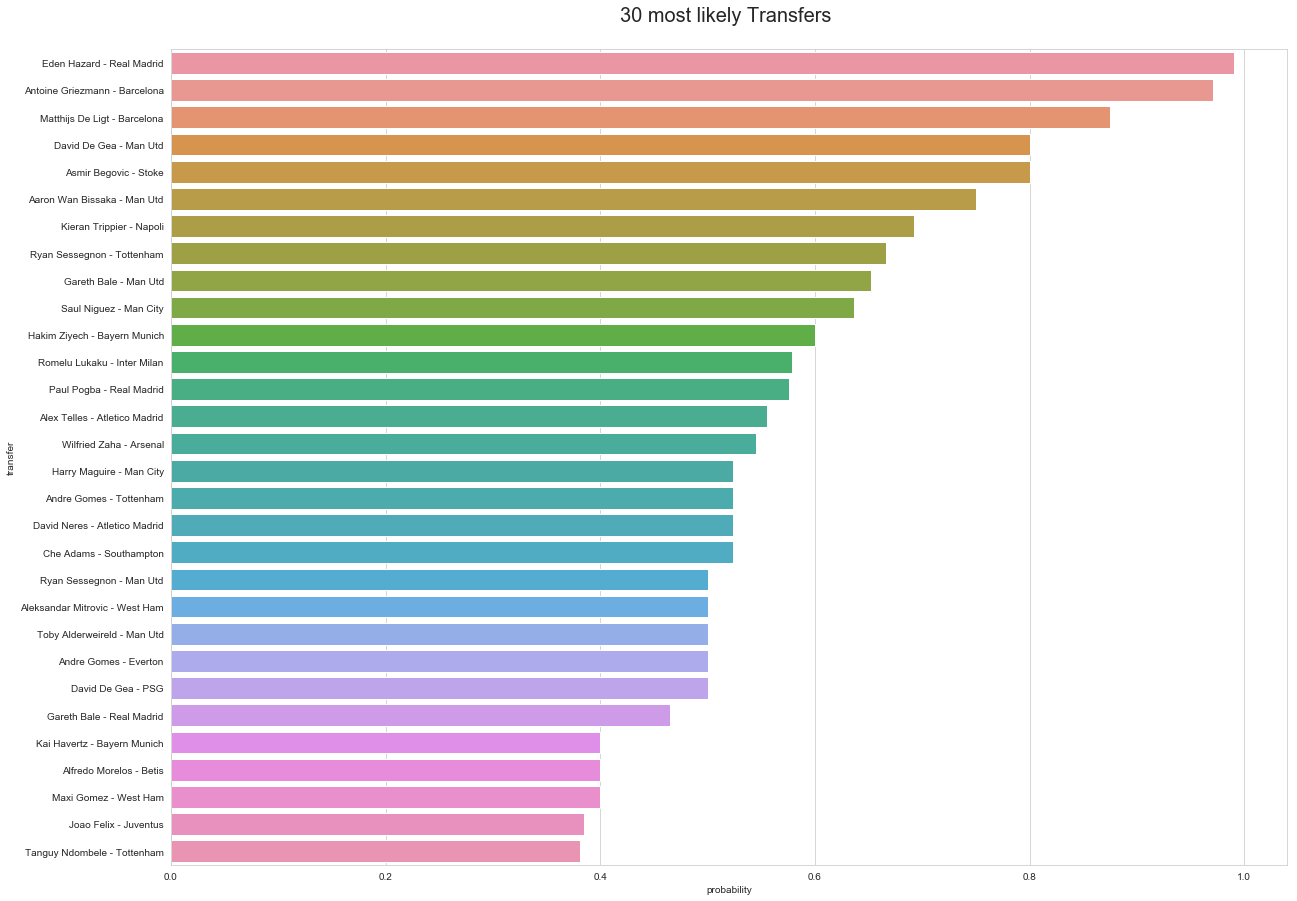

In [11]:
plot_most_likely(combined_df, 30)

In [12]:
combined_df.to_csv(f'output/data/{datetime.now().date()}.csv')
print(datetime.now())

2019-05-24 01:04:45.525668
